Prediccion de precios de cryptos. Usando protocolo 2 (normalizacion de ventanas en vez de normalizacion global).

Pucheta Mauro.


CARGA DE DATOS


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
from sklearn.preprocessing import MinMaxScaler

while not os.path.exists('datos_1h_limpios_V1.csv'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
### load in and normalize the dataset

dataset = np.genfromtxt('datos_1h_limpios_V1.csv', delimiter=',')
#datos tiene la forma Instancia X (date,timestamp(de la fecha),Open,	High,	Low,	Close,	Volume From,	Volume To)
#datos_1h tiene la forma timestamp,Open,High, Low,Close. volume from, volume to no es necesario la timestamp para predecir, pero si para plotear
#una alternativa es usar pandas.read_csv(file) directamente y puedo trabajar con los labels.

Saving datos_1h_limpios_V1.csv to datos_1h_limpios_V1.csv
User uploaded file "datos_1h_limpios_V1.csv" with length 557162 bytes


Definicion de datos, slices en porciones de training y test para el modelo. Algunas cosas parecen medias oscuras. Por ejemplo


close=dataset[ : , 4]

Esto es porque cuando se hizo un preprocesamiento de los datos, el valor de "close" de la cryptomoneda queda en la columna 4....

In [0]:
training_factor=0.7 # con 0.6 el 60% del total va para training


timestamp=dataset[:,0] 
timestamp=timestamp[::-1] #invierto, porque las timestamps quedaban al revez


close=dataset[:,4] 
close=close[::-1]


train_test_frontera=int(len(close)*training_factor) #establezco la frontera de acuerdo al total de los datos y el porcentaje indicado en training_factor
while((train_test_frontera%32)!=0): #habia un problema si los datos no se podian ddividir en 32 por el batch size de las LSTM
  train_test_frontera+=1


datos_train=close[:train_test_frontera]
datos_test=close[train_test_frontera:]

Definicion de tratamiendo de normalizacion y de ventanas. Si bien se hizo PASOS_A_PREDECIR=1, se considera que es mejor no poenr otro valor
(no predecir mas que el proximo paso).

In [0]:
WINDOW_SIZE=8
'''
en cuantos pasos anteriores me baso para predecir, si los datos venian de a dias,
window_size=7 me indica que me baso en los datos de la semana anterior para predecir
'''

PASOS_A_PREDECIR=1
'''
De acuerdo a cada cuanto se miden los datos puedo predecir N pasos a futuro (cada vez con menor certidumbre). 
Por ejemplo mediciones de un dia y pasos_a_predecir=1 indica que solo hago prediccion del siguiente dia considerando 
una ventana de window_size
'''

def normalizarWindow(scaler,datos, porcionX,porcionY):
    scaler.fit(datos.reshape(-1,1))
    nuevoX=scaler.transform(porcionX.reshape(-1,1))
    nuevoY=scaler.transform(porcionY.reshape(-1,1))
    return nuevoX,nuevoY
  
def desnormalizarData(scaler,data):
    return scaler.inverse_transform(data) #o sea, puedo cambiar el scaler. 
  
def separarEnWindows(datos, windowSize,pasosFuturos):
  x=[]
  y=[]
  scaler= MinMaxScaler()
  
  for i in range(0,len(datos)-pasosFuturos-windowSize):
      
      nuevoX,nuevoY=normalizarWindow(scaler,datos[i:i+windowSize+PASOS_A_PREDECIR],datos[i:i+windowSize],datos[i+windowSize:i+windowSize+pasosFuturos])
    
      x.append(nuevoX)
      y.append(nuevoY)

      
  
  
  x=np.asarray(x)
  
  x.shape=np.shape(x)[0:3]#son ventanas de window_size
 
  y=np.asarray(y) #el output es un valor, que es el valor de prediccion de cierre
  y.shape=np.shape(y)[0:2]
  
  return x,y

x_train=[]
y_train=[]
x_test=[]
y_test=[]

#x,y=separarEnWindows(datos_train,WINDOW_SIZE,PASOS_A_PREDECIR)
#si hago print(y.shape) sale (train_test_frontera-window_size,) pero tiene filas x WindowSize (pero es toda una lista, por lo que no hay varias columnas si no que es una sola columna?)

x_train,y_train=separarEnWindows(datos_train,WINDOW_SIZE,PASOS_A_PREDECIR)

x_test,y_test=separarEnWindows(datos_test,WINDOW_SIZE,PASOS_A_PREDECIR)


Definicion del modelo de prediccion. La arquitectura son varias layers de LSTM para predecir un unico valor (el siguiente valor en base a los anteriores).

El early stopping esta por si se quiere dejar entrenando por muchos epochs.
Como es un problema de regresion mas que de clasificacion, se usan metricas que miden una cierta diferencia con el valor real. El mas significativo era el mean_squared_error.



In [4]:
from keras.layers import Dense, LSTM, Input, Bidirectional, Conv1D,Flatten,BatchNormalization, Dropout, TimeDistributed, Activation,Lambda,RNN,GRU, RepeatVector
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


#HIPERPARAMETROS

BATCH_SIZE=256
EPOCHS=1500
OPTIMIZER= RMSprop(lr=0.005, rho=0.9, epsilon=1e-08, decay=1e-6)
LOSS='mean_squared_error'
METRICS=['mean_squared_error']

stopping=EarlyStopping(monitor='loss', min_delta=1e-6, patience=100, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
UNITS=WINDOW_SIZE*3

i = Input(shape=(WINDOW_SIZE,1))
l = LSTM(UNITS,unroll=True,return_sequences=True)(i)

l = LSTM(UNITS,unroll=True,return_sequences=True)(l)
d=  LSTM(1)(l)

model= Model(inputs=i,outputs=d)

model.summary()
model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)



Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 24)             2496      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 24)             4704      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 104       
Total params: 7,304
Trainable params: 7,304
Non-trainable params: 0
_________________________________________________________________


In [5]:
"""
h=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=[x_test,y_test],callbacks=[stopping])

#GRAFICO DE PERDIDAS
v_loss = h.history['val_loss']
loss = h.history['loss']
plt.plot(range(len(loss)), loss, '-r')
plt.plot(range(len(v_loss)), v_loss, '-b')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

"""
#CARGAR MODELO

from keras.models import model_from_json
import numpy
import os.path

while not os.path.exists('model.json'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

while not os.path.exists('model.h5'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

          
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")
loaded_model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
score = loaded_model.evaluate(x_test, y_test, verbose=0)
for i in range(0,len(loaded_model.metrics_names)):
  print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))
  
model=loaded_model

Saving model.json to model.json
User uploaded file "model.json" with length 3114 bytes


Saving model.h5 to model.h5
User uploaded file "model.h5" with length 45392 bytes
Loaded model from disk
loss: 7.46%
mean_squared_error: 7.46%


Lo siguiente es para abstraer el manejo de la entrada. El modelo necesita de 3 dimensiones, y poner a cada rato x.reshape(1,WINDOW_SIZE,1) dificultaba la lectura del codigo

In [0]:
def transformarA3D(datos,dim1,dim2,dim3):
  #la entrada del modelo requiere 3 dim
  return datos.reshape(dim1,dim2,dim3)



PREDICCION COMPLETA. Cada punto se predice en base a los "WINDOW_SIZE" anteriores. Ej, si WINDOW_SIZE es 4, me baso en los 4 pasos anteriores para predecir el proximo valor. Notese que cada prediccion se hace en base a los valores reales. Por cada prediccion realizada muevo la ventana un paso en el futuro.

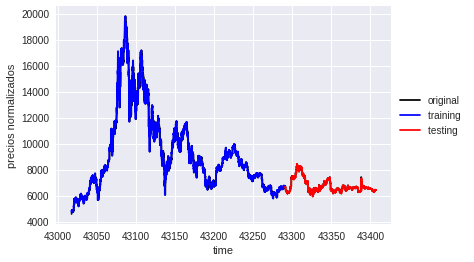

In [7]:
split_train = train_test_frontera - WINDOW_SIZE - PASOS_A_PREDECIR
split_test = train_test_frontera + WINDOW_SIZE + PASOS_A_PREDECIR

prediccion_train=[]
prediccion_test=[]

scaler=MinMaxScaler()
datos=close #datos sin normalizar

for i in range(WINDOW_SIZE,len(datos_train)-PASOS_A_PREDECIR):
  porcion=datos_train[i-WINDOW_SIZE:i+PASOS_A_PREDECIR] 
  porcionX=porcion[:-PASOS_A_PREDECIR]
  porcionY=porcion[-PASOS_A_PREDECIR:]

  x,y=normalizarWindow(scaler,porcion,porcionX,porcionY)
  x=transformarA3D(x,1,WINDOW_SIZE,PASOS_A_PREDECIR) #paso a representacion de instancia,ventana,valorPredicho
  prediccion=model.predict(x)

  prediccion_train.append(desnormalizarData(scaler,prediccion).reshape(PASOS_A_PREDECIR))
  
for i in range(WINDOW_SIZE,len(datos_test)-PASOS_A_PREDECIR):
  porcion=datos_test[i-WINDOW_SIZE:i+PASOS_A_PREDECIR] 
  porcionX=porcion[:-PASOS_A_PREDECIR]
  porcionY=porcion[-PASOS_A_PREDECIR:]

  x,y=normalizarWindow(scaler,porcion,porcionX,porcionY)
  x=transformarA3D(x,1,WINDOW_SIZE,PASOS_A_PREDECIR) #paso a representacion de instancia,ventana,valorPredicho
  prediccion=model.predict(x)
  
  prediccion_test.append(desnormalizarData(scaler,prediccion).reshape(PASOS_A_PREDECIR))
  

plt.plot(timestamp,close,color='black') #son los datos originales del dataset
plt.plot(timestamp[:split_train],prediccion_train,color = 'b') #imprime lo predicho sobre los datos de training

# plot testing set prediction
plt.plot(timestamp[split_test:],prediccion_test,color = 'r') #imprime lo predicho sobre los datos de testing


plt.xlabel('time')
plt.ylabel('precios normalizados')
plt.legend(['original','training ','testing '],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

Lo proximo es la misma prediccion, del proximo valor en base a los valores reales. Sin embargo aca se permite ver de a segmentos mas chicos.
Esto permite ver que en la imagen general la prediccion es perfecta, pero vista de a segmentos hay variaciones (en general, la curva predicha es mas suave que los valores reales)

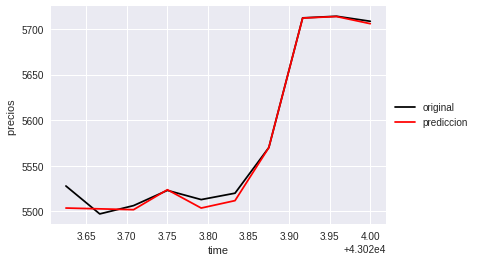

In [8]:
plt.clf()
comienzoPlot=150
finPlot=160


datos=close  #datos sin normalizar
plt.plot(timestamp[comienzoPlot:finPlot],datos[comienzoPlot:finPlot],color='black') #son los datos originales del dataset



#debo normalizar las ventanas para predecir
predicciones=[]

scaler=MinMaxScaler()

sliceDatos=datos[comienzoPlot-WINDOW_SIZE:finPlot+PASOS_A_PREDECIR] #si quiero predecir 150 a 600. tomo de 150-ventana (para predecir 150) hasta 600+PASOS. 
for i in range(WINDOW_SIZE,len(sliceDatos)-PASOS_A_PREDECIR):
  porcion=sliceDatos[i-WINDOW_SIZE:i+PASOS_A_PREDECIR] 
  porcionX=porcion[:-PASOS_A_PREDECIR]
  porcionY=porcion[-PASOS_A_PREDECIR:]

  x,y=normalizarWindow(scaler,porcion,porcionX,porcionY)
  x=transformarA3D(x,1,WINDOW_SIZE,PASOS_A_PREDECIR) #paso a representacion de instancia,ventana,valorPredicho
  prediccion=model.predict(x)
  
  predicciones.append(desnormalizarData(scaler,prediccion).reshape(PASOS_A_PREDECIR))
 


plt.plot(timestamp[comienzoPlot:finPlot],predicciones,color = 'r') 






plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','prediccion'],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

Definicion de un segundo modelo, se va a utilizar para predecir en base a lo que predijo la red. Es decir, la salida de la red vuelve a ser input para seguir prediciendo en base a eso.

In [9]:
i = Input(batch_shape=(1,WINDOW_SIZE,1))

l = LSTM(UNITS,unroll=True,return_sequences=True,stateful=True)(i) #ver de cambiar stateful=True

l = LSTM(UNITS,unroll=True,return_sequences=True,stateful=True)(l)

d = LSTM(1)(l)


nuevoModel= Model(inputs=i,outputs=d)
nuevoModel.summary()

nuevoModel.set_weights(model.get_weights())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 8, 1)                 0         
_________________________________________________________________
lstm_4 (LSTM)                (1, 8, 24)                2496      
_________________________________________________________________
lstm_5 (LSTM)                (1, 8, 24)                4704      
_________________________________________________________________
lstm_6 (LSTM)                (1, 1)                    104       
Total params: 7,304
Trainable params: 7,304
Non-trainable params: 0
_________________________________________________________________


Generacion de datos a partir de la salida. En general lo que se hace es definir un punto de partida (frontera_predecir) a partir del cual empiezan las predicciones.

Luego, para hacer cada prediccion se toma una ventana de datos. Esta ventana se particiona en una porcionX y una porcionY como se hacia antes. Lo unico que aca la porcionY no se utiliza.

Se hace una prediccion en base a la porcionX y se la ubica como nuevo valor:

"predicciones_recurrentes[indiceDestinoStart:indiceDestinoFin]=desnormalizarData(scaler,pred) "

Este nuevo valor ya no es el real, si no una prediccion, y va a ser utilizada en la proxima iteracion para definir una nueva ventana (con una nueva normalizacion) para generar nuevas salidas.

Se espera que en algun momento, si el numero de predicciones es muy grande, se estabilice la curva en algun valor.



(9353, 1)


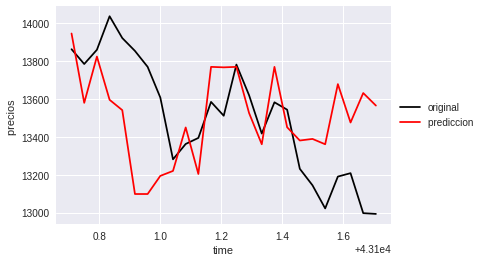

In [10]:
numPredicciones=25
frontera_predecir=2000
datos=close
scaler=MinMaxScaler()
  
predicciones_recurrentes=np.empty((len(datos),1)) #instancias,1 feature
predicciones_recurrentes[:]=datos[:].reshape(len(datos),1) #toy manejando los datos tal cual estan en los datos, los datos puestos en ventanas son para training y predict. Aca estoy generando nuevos datos

nuevoModel.reset_states()


print(predicciones_recurrentes.shape)

for i in range(0,numPredicciones):
 
  indiceDestinoStart=frontera_predecir+i
  indiceDestinoFin=frontera_predecir+i+PASOS_A_PREDECIR
  indiceSourceVentanaStart=frontera_predecir-WINDOW_SIZE-1+i
  indiceSourceVentanaFin=frontera_predecir+i
  #hasta aca tengo ventanas, pero no estan normalizadas. Ademas, por cada nueva prediccion tengo que renormalizar
  
  
  porcion=predicciones_recurrentes[indiceSourceVentanaStart:indiceSourceVentanaFin] 
  
  porcionX=porcion[:-PASOS_A_PREDECIR]
  porcionY=porcion[-PASOS_A_PREDECIR:] #esto es similar a lo anterior, solo que porcionY luego se va a pisar por la nueva prediccion
  
  
  x,y=normalizarWindow(scaler,porcion,porcionX,porcionY)
  x=transformarA3D(x,1,WINDOW_SIZE,PASOS_A_PREDECIR)
  
  pred=nuevoModel.predict(x)
  predicciones_recurrentes[indiceDestinoStart:indiceDestinoFin]=desnormalizarData(scaler,pred) 
  
plt.clf()


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],datos[frontera_predecir:frontera_predecir+numPredicciones],color='black') #son los datos originales del dataset


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],predicciones_recurrentes[frontera_predecir:frontera_predecir+numPredicciones],color = 'r') 






plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','prediccion '],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

Lo siguiente se realiza para ver como se generan las predicciones a gran escala. Es parecido a lo anterior solo que cuando se genera una ventana nueva con datos predichos se resetean los datos con los originales (cada "RESET" predicciones). Es decir, se predicen segmentos de "RESET"  y luego se resetea para ver otros segmentos.

Es como si definiera muchos puntos de partida, por cada punto de partida hago predicciones considerando la salida de la Red Neuronal. Una vez que llego al proximo punto de partida, no utilizo mas las predicciones hechas, si no que reestablezco los valores.

Es mas de "tendencias" que de valores absolutos.



(9353, 1)


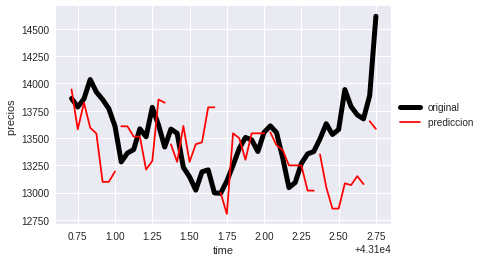

In [11]:
numPredicciones=50
frontera_predecir=2000
RESET=8

predicciones_recurrentes=np.empty((len(datos),1)) #instancias,1 feature
predicciones_recurrentes[:]=datos[:].reshape(len(datos),1)




print(predicciones_recurrentes.shape)

predicciones_plot=[]

for i in range(0,numPredicciones):
 
 

    
  indiceDestinoStart=frontera_predecir+i
  indiceDestinoFin=frontera_predecir+i+PASOS_A_PREDECIR
  indiceSourceVentanaStart=frontera_predecir-WINDOW_SIZE-1+i
  indiceSourceVentanaFin=frontera_predecir+i
  
  if((i%(RESET))==0): #incluye reseteo en la primer ejecucion
    nuevoModel.reset_states() #reseteo estados, no quiero que los estados que venian sean la proxima entrada. En la proxima predicción se van a setear nuevos estados
    predicciones_recurrentes[:]=datos[:].reshape(len(datos),1) #reset de los datos para la proxima trend


  
  
  scaler=MinMaxScaler()
  porcion=predicciones_recurrentes[indiceSourceVentanaStart:indiceSourceVentanaFin] 
  
  porcionX=porcion[:-PASOS_A_PREDECIR]
  porcionY=porcion[-PASOS_A_PREDECIR:] #esto es similar a lo anterior, solo que porcionY luego se va a pisar por la nueva prediccion
  
  
  x,y=normalizarWindow(scaler,porcion,porcionX,porcionY)
  x=transformarA3D(x,1,WINDOW_SIZE,PASOS_A_PREDECIR)
  
  pred=nuevoModel.predict(x)
  
  pred=desnormalizarData(scaler,pred) 
  predicciones_recurrentes[indiceDestinoStart:indiceDestinoFin]=pred

  predicciones_plot.append(pred)
  #print(pred)


  

predicciones_plot=np.asarray(predicciones_plot).reshape(numPredicciones,1)

plt.clf()


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],datos[frontera_predecir:frontera_predecir+numPredicciones],color='black',linewidth=5) #son los datos originales del dataset


split_pred=numPredicciones%RESET


for i in range(0,numPredicciones-split_pred,RESET):
  
  plt.plot(timestamp[frontera_predecir+i:frontera_predecir+i+RESET],predicciones_plot[i:i+RESET],color = 'r') 

plt.plot(timestamp[frontera_predecir+numPredicciones-split_pred:frontera_predecir+numPredicciones],predicciones_plot[numPredicciones-split_pred:numPredicciones],color = 'r') #printeo lo que faltaba que no entraba en las window

plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','prediccion '],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

In [12]:
"""
#GUARDAR MODELO

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


#despues poner que baje el archivo este "model.h5" que corre en esta maquina virtual que está corriendo
#el jupyter notebook. Se baja mediante el colab.download que use en la clase 3
from google.colab import files
files.download("model.h5")
files.download("model.json")
"""


'\n#GUARDAR MODELO\n\n# serialize model to JSON\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model.h5")\nprint("Saved model to disk")\n\n\n#despues poner que baje el archivo este "model.h5" que corre en esta maquina virtual que está corriendo\n#el jupyter notebook. Se baja mediante el colab.download que use en la clase 3\nfrom google.colab import files\nfiles.download("model.h5")\nfiles.download("model.json")\n'

In [13]:
"""
#CARGAR MODELO

from keras.models import model_from_json
import numpy
import os.path

while not os.path.exists('model.json'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

while not os.path.exists('model.h5'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

          
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")
loaded_model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
score = loaded_model.evaluate(x_test, y_test, verbose=0)
for i in range(0,len(loaded_model.metrics_names)):
  print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))
  
  
model=loaded_model
"""

'\n#CARGAR MODELO\n\nfrom keras.models import model_from_json\nimport numpy\nimport os.path\n\nwhile not os.path.exists(\'model.json\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\nwhile not os.path.exists(\'model.h5\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\n          \njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\n\nprint("Loade